In [17]:
import socket
import os

print(socket.gethostname())
print(os.getcwd())

sampo3
/research/work/johanneo/qclus/qclus/tutorials


In [18]:
%load_ext autoreload
%autoreload 2

import qclus as qc
import scanpy as sc
import pandas as pd
from qclus.gene_lists import *

import warnings
warnings.filterwarnings("ignore")

In [19]:
loompy_path = "../../../../../groups/Linna_Lab/paavo_data/sample_lq.loom"

In [20]:
fraction_unspliced = qc.utils.fraction_unspliced_from_loom(loompy_path)

In [21]:
fraction_unspliced

,fraction_unspliced
AAACGAACATTCTCTA,0.523716
AAACGAAAGCCGCTTG,0.505452
AAACGCTCACGCTGTG,0.435658
AAACGAACAACTGCTA,0.385696
AAACGCTGTGGGTATG,0.624506
...,...
TTTGTTGGTCCTGGTG,0.595714
TTTGTTGTCCTAAACG,0.695590
TTTGTTGTCTACTGAG,0.496416
TTTGTTGTCGATTGGT,0.659710


In [22]:
counts_path = "../../../../../groups/Linna_Lab/paavo_data/sample_lq.h5"

In [23]:
adata = qc.run_qclus(counts_path, fraction_unspliced,
                        gene_set_dict=celltype_gene_set_dict,           # exact gene sets can be found in gene_lists.py
                        nucl_gene_set=nucl_genes_50,                    # exact gene set can be found in gene_lists.py
                        minimum_genes=500,                              # minimum number of detected genes allowed in droplet
                        maximum_genes=6000,                             # maximum number of detected genes allowed in droplet
                        max_mito_perc=40,                               # maximum percentage of mitochondrial content allowed in droplet
                        clustering_features=[
                                        #'pct_counts_nonCM',        # Clustering features as defined in publication
                                        'pct_counts_nucl_30',           
                                        'pct_counts_MT',            
                                        #'pct_counts_CM_cyto', 
                                        #'pct_counts_CM_nucl', 
                                        'fraction_unspliced'], 
                        clustering_k=4,                                 # number of clusters to generate
                        clusters_to_select=["0", "1"],                  # which clusters, in order of quality, to select
                        scrublet_filter=True,                           # whether or not to apply the Scrublet algorith,
                        scrublet_expected_rate=0.06,                    
                        scrublet_minimum_counts=2,                      
                        scrublet_minimum_cells=3,                       
                        scrublet_minimum_gene_variability_pctl=85,      
                        scrublet_n_pcs=30,                              
                        scrublet_thresh=0.1,                            
                        outlier_filter=True,                            # whether or not to apply outlier filter
                        outlier_unspliced_diff=0.1,                     # outlier filter setting
                        outlier_mito_diff=5)                            # outlier filter setting


In [24]:
adata

AnnData object with n_obs × n_vars = 31670 × 36601
    obs: 'fraction_unspliced', 'pct_counts_MT', 'total_counts', 'n_genes_by_counts', 'kmeans', 'qclus'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'QClus'

In [25]:
adata.obs.qclus.value_counts()

qclus
clustering filter    14880
passed                8473
outlier filter        4242
scrublet filter       3952
initial filter         123
Name: count, dtype: int64

In [26]:
#filter out initial_filter annotated cells
adata = adata[adata.obs.qclus!="initial filter"]
adata.obsm["QClus"] = adata.uns["QClus"]

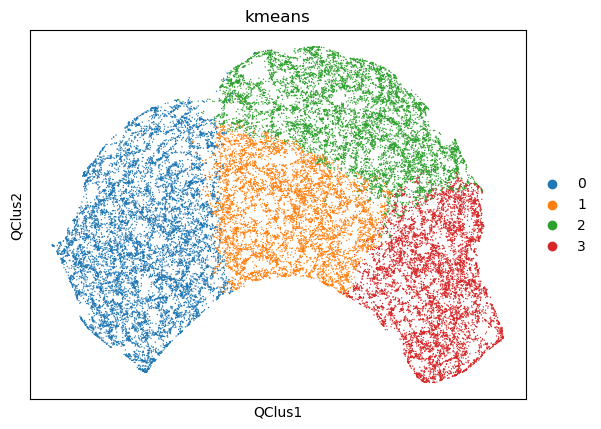

In [27]:
%matplotlib inline
sc.pl.embedding(adata, basis="QClus", color="kmeans")

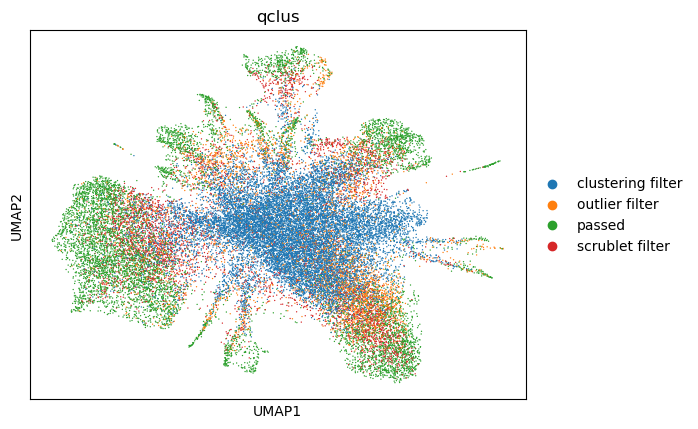

In [28]:
#run standard processing for visualization purposes
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

#save raw dataset and filter genes
adata.raw = adata
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.filter_genes(adata, min_cells=10)
adata = adata[:, adata.var.highly_variable]

# Use the determined number of cores in sc.pp.regress_out
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_MT'], n_jobs=4)


sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, svd_solver='randomized')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden")

sc.pl.umap(adata, color="qclus")

In [29]:
adata = adata[adata.obs.qclus=="passed"]
adata

View of AnnData object with n_obs × n_vars = 8473 × 2746
    obs: 'fraction_unspliced', 'pct_counts_MT', 'total_counts', 'n_genes_by_counts', 'kmeans', 'qclus', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells', 'mean', 'std'
    uns: 'QClus', 'kmeans_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'qclus_colors'
    obsm: 'QClus', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

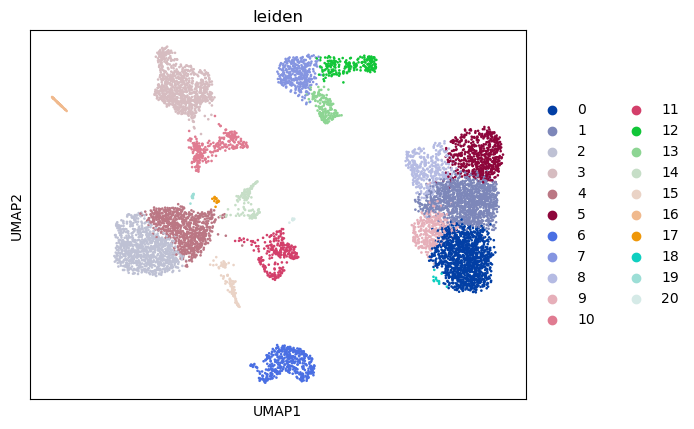

In [30]:
sc.tl.pca(adata, svd_solver='randomized')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden")

sc.pl.umap(adata, color="leiden")

In [31]:
def annotate_celltypes(df, leiden_key, key_added):
    df[key_added] = ["NA" for x in range(len(df.index))]
    for cluster in set(df[leiden_key]):
        subset_adata = df[df[leiden_key] == cluster]
        celltype = subset_adata[['score_VEC', 
                                 'score_PER', 
                                 'score_SMC', 
                                 'score_AD', 
                                 'score_SC', 
                                 'score_N', 
                                 'score_EEC', 
                                 'score_FB', 
                                 'score_L', 
                                 'score_MESO', 
                                 'score_MP', 
                                 'score_CM_nucl']].mean().idxmax().split("_")[1]
        df.loc[df[leiden_key] == cluster, key_added] = celltype
    return df[key_added].to_list()

In [32]:
sc.tl.leiden(adata, key_added="leiden_3", resolution=3)        
adata.obs["cell_type"] = annotate_celltypes(adata.obs.copy(), "leiden_3", "cell_type")  

KeyError: "None of [Index(['score_VEC', 'score_PER', 'score_SMC', 'score_AD', 'score_SC',\n       'score_N', 'score_EEC', 'score_FB', 'score_L', 'score_MESO', 'score_MP',\n       'score_CM_nucl'],\n      dtype='object')] are in the [columns]"

In [ ]:
sc.pl.umap(adata, color="cell_type")

In [ ]:
sc.tl.rank_genes_groups(adata, groupby="cell_type", method="wilcoxon")
for cell_type in set(adata.obs.cell_type):
    adata_subset = adata[adata.obs.cell_type == cell_type]
    sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=60, cmap="viridis_r", key=cell_type)